In [1]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Import necessary libraries
import pyspark.sql.functions as F
import pyspark.ml.feature as feat
import pyspark.ml.classification as cl
import pyspark.ml.evaluation as eval
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
import seaborn as sns
import pandas as pd

In [4]:
# Create a SparkSession
spark = SparkSession.builder.appName('CreditCardFraudDetection').getOrCreate()

# Load the dataset into a PySpark DataFrame
df = spark.read.format('csv').options(header='true', inferSchema='true').load('creditcard.csv')


In [5]:
# Drop unnecessary columns
df = df.drop('Time')

In [6]:
# Removing duplicates
df = df.dropDuplicates()

In [7]:
from pyspark.sql.functions import count, when, isnull
# Drop rows with any null value
df_clean = df.dropna()

# Check null values 
df_clean.select([count(when(isnull(c), c)).alias(c) for c in df_clean.columns]).show()


+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
| V1| V2| V3| V4| V5| V6| V7| V8| V9|V10|V11|V12|V13|V14|V15|V16|V17|V18|V19|V20|V21|V22|V23|V24|V25|V26|V27|V28|Amount|Class|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+
|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|     0|    0|
+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+------+-----+



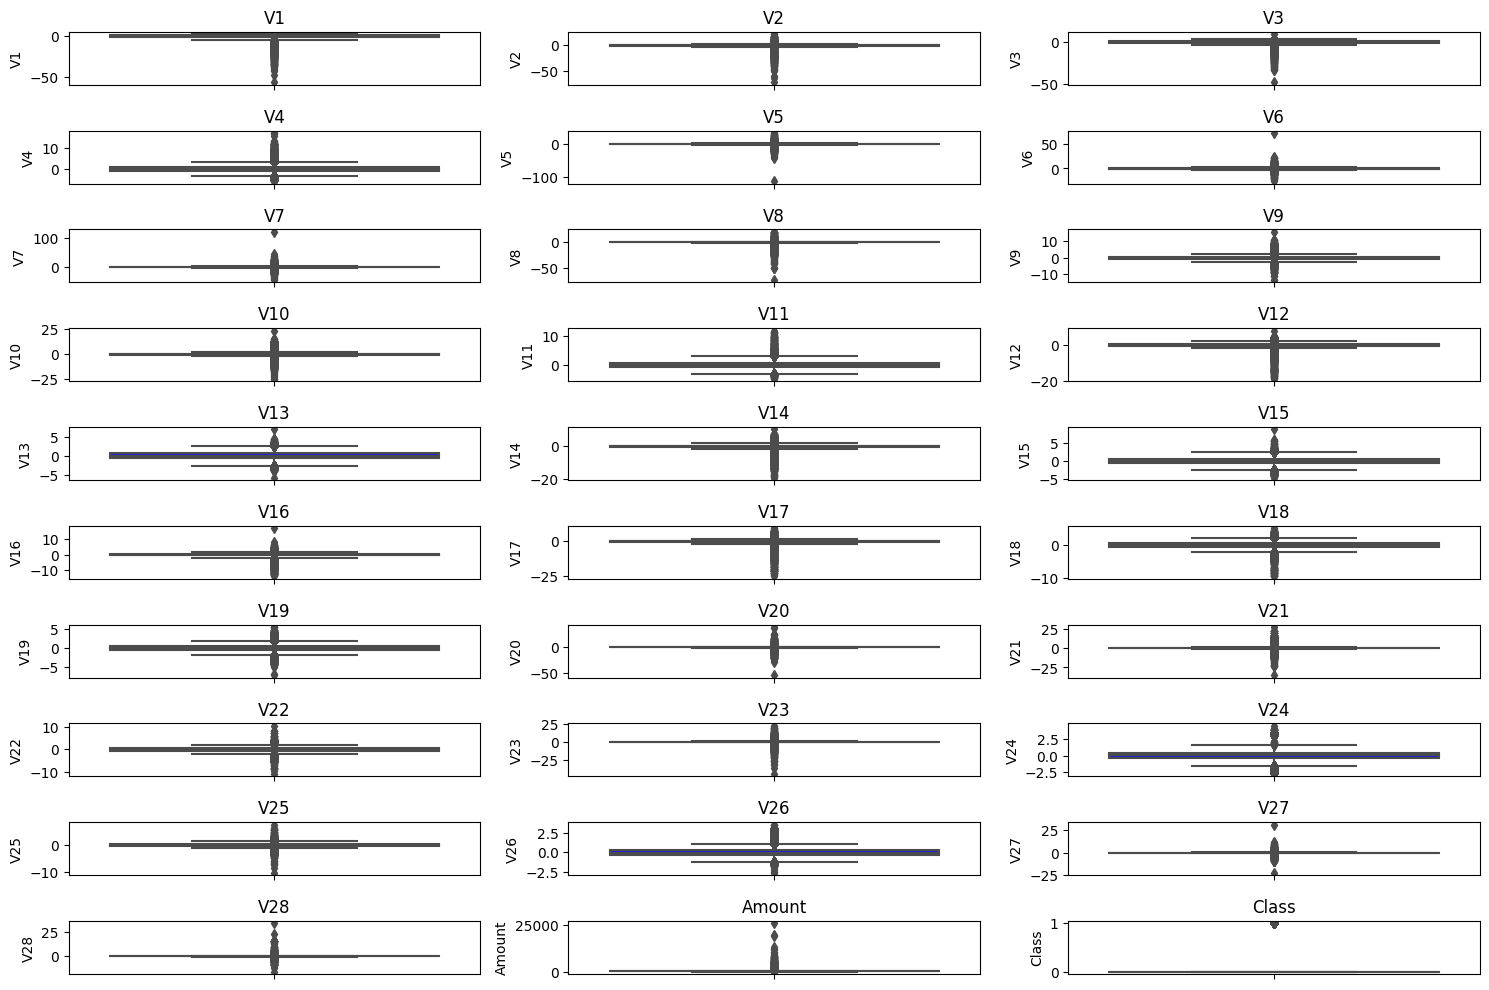

In [8]:
import math

# Checking for outliers using box plots
# Select only numerical columns from the DataFrame
num_cols = [c for c,t in df.dtypes if t in ['double', 'int', 'float']]
numeric_df = df.select(num_cols)

# Calculate the number of rows and columns required for the grid
n_cols = 3
n_rows = math.ceil(len(num_cols) / n_cols)

# Create a grid of box plots for each numerical column
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(num_cols):
    sns.boxplot(y=column, data=numeric_df.toPandas(), color='blue', ax=axes[i])
    axes[i].set_title(column)

# Hide empty subplots
for j in range(i+1, n_rows * n_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


This code snippet loops over all columns in the DataFrame and casts each column to double data type using the withColumn() method and the cast() function. After this, you can perform your desired operation on the V22 column.

In [9]:
from pyspark.sql.functions import col

# Cast all columns to double data type
for c in df.columns:
    df = df.withColumn(c, col(c).cast('double'))

In [11]:
df.select('V22').show(10)


+------------------+
|               V22|
+------------------+
|   1.4009620012101|
| 0.345636645537861|
| 0.478377507771621|
|  -0.7011709151624|
| 0.500651283791789|
|-0.789994037643152|
| -0.48602217178527|
|-0.592334224716281|
|-0.224655183830571|
| -1.16987445211449|
+------------------+
only showing top 10 rows



**Scaling**: Next I am using Standard Scaler which transforms the data to have a zero mean and unit standard deviation. I have chosen it because it gets affected by outliers unlike min max scaling, and I think that when we talk about fraud and unusual transactions then there is a good chance that outliers would belong to this category.


In [58]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

# Create a VectorAssembler to combine the "Amount" column into a vector column
assembler = VectorAssembler(inputCols=["Amount"], outputCol="AmountVector")

# Apply the VectorAssembler to the DataFrame
df_assembled = assembler.transform(df_clean)

# Scale the "AmountVector" column using StandardScaler
scaler = StandardScaler(inputCol="AmountVector", outputCol="AmountScaled")
scalerModel = scaler.fit(df_assembled)
df_scaled = scalerModel.transform(df_assembled)

# Select only the scaled "Amount" column
df_scaled.select("AmountScaled").show()


+--------------------+
|        AmountScaled|
+--------------------+
|[0.2764460599688202]|
|[0.13423430826200...|
|[0.22510607740318...|
|[0.00394922942812...|
|[0.01259804187572...|
|[0.00781947426768...|
|[0.00912271997897...|
|[0.01974614714063...|
|[0.05224830533410...|
|[0.00781947426768...|
|[0.1347477080876592]|
|[0.00702962838206...|
|[1.0415302770796708]|
|[1.0875387999173387]|
|[0.2830807654080719]|
|[0.02961922071094...|
|[3.94922942812600...|
|[0.0486150142602311]|
|[1.0658970226512081]|
|[0.17724141673429...|
+--------------------+
only showing top 20 rows



Next , Let's count the instances of normal and fraud classes before applying over sampling technique:

In [59]:
from pyspark.sql.functions import col

# Group by Class column and count the number of occurrences
class_count_df = df_clean.groupBy('Class').count().withColumnRenamed('count', 'Counts')

# Replace Class values with Normal and Fraud
class_count_df = class_count_df.withColumn('Class', 
                                           when(col('Class') == 0, 'Normal')
                                           .otherwise('Fraud'))

# Convert to Pandas DataFrame and display
class_count_df = class_count_df.toPandas()
print(class_count_df.head())


    Class  Counts
0   Fraud     473
1  Normal  275190


<Axes: xlabel='Class'>

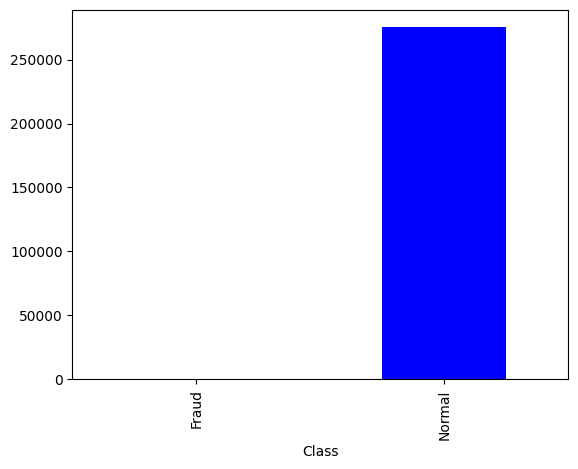

In [60]:
import pandas as pd
import pyspark.sql.functions as F

# Convert the PySpark DataFrame to a Pandas DataFrame
class_count_df = df_scaled.groupby("Class").count().withColumnRenamed("count", "Counts").toPandas()

# Replace the Class values
class_count_df["Class"] = class_count_df["Class"].replace({0: "Normal", 1: "Fraud"})

# Plot the counts using a bar chart
class_count_df.plot(kind="bar", x="Class", y="Counts", legend=False, color=["blue", "blue"])


In [10]:
from imblearn.over_sampling import SMOTE
from pyspark.sql.functions import col

# Create an instance of SMOTE class
smote = SMOTE()

# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df_clean.toPandas()

# Split features and target columns
X = pandas_df.drop('Class', axis=1)
y = pandas_df['Class']

# Perform SMOTE on training data
X_resampled, y_resampled = smote.fit_resample(X, y)

# Combine resampled features and target columns
resampled_df = pd.concat([X_resampled, y_resampled], axis=1)

# Convert Pandas DataFrame back to PySpark DataFrame
df_resampled = spark.createDataFrame(resampled_df)

# Check the new distribution of the target variable
df_resampled.groupBy('Class').count().orderBy(col('count').desc()).show()


+-----+------+
|Class| count|
+-----+------+
|    0|275190|
|    1|275190|
+-----+------+



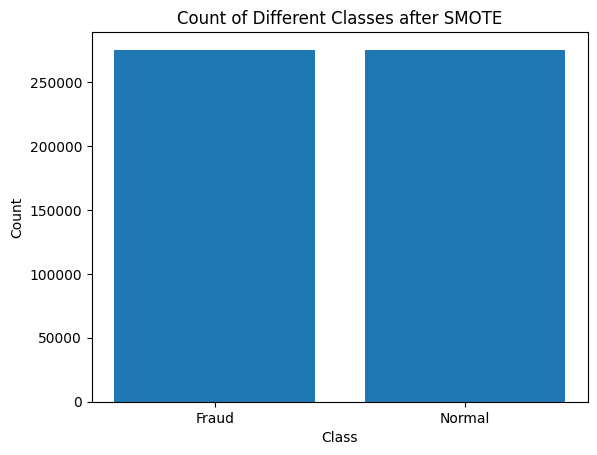

In [62]:
import matplotlib.pyplot as plt

# Get the count of each class
fraud_count = df_resampled.filter(df_resampled.Class == 1).count()
normal_count = df_resampled.filter(df_resampled.Class == 0).count()

# Create a bar chart
plt.bar(['Fraud', 'Normal'], [fraud_count, normal_count])

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Count of Different Classes after SMOTE')

# Display the plot
plt.show()


ML Algorithms

Logistic Regression is a popular algorithm used for binary classification tasks. It models the relationship between the dependent and the independent variables using the logistic function. Logistic Regression estimates the probabilities of the binary outcome based on the input features and applies a threshold to make predictions. It is computationally efficient, interpretable, and works well with linearly separable data.


In [35]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

# Convert the AmountScaled column to a vector
assembler = VectorAssembler(inputCols=df_resampled.columns[:-3], outputCol="features3")
df_resampled = assembler.transform(df_resampled)

# Split the data into training and testing sets
(training_data, testing_data) = df_resampled.randomSplit([0.7, 0.3], seed=42)

# Train a logistic regression model
lr = LogisticRegression(featuresCol="features3", labelCol="Class")
model = lr.fit(training_data)

# Make predictions on the testing data
predictions = model.transform(testing_data)

# Evaluate the model using precision, recall, F1 score, and AUC-ROC
evaluator = BinaryClassificationEvaluator(labelCol="Class")
auc_roc = evaluator.evaluate(predictions)

evaluator1 = MulticlassClassificationEvaluator(labelCol="Class", metricName="weightedPrecision")
precision = evaluator1.evaluate(predictions)

evaluator2 = MulticlassClassificationEvaluator(labelCol="Class", metricName="weightedRecall")
recall = evaluator2.evaluate(predictions)

evaluator3 = MulticlassClassificationEvaluator(labelCol="Class", metricName="f1")
f1_score = evaluator3.evaluate(predictions)

evaluator4 = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderPR")
auprc_dt = evaluator4.evaluate(predictions)

print("AUC-ROC:", auc_roc)
print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1_score)
print("AUPRC = %g" % auprc_dt)



AUC-ROC: 0.998142266552781
Precision: 0.9806622493322064
Recall: 0.9806113537117904
F1 score: 0.9806104644664303
AUPRC = 0.979581


**Evaluation Metrics:**
**Precision** is a metric that measures the accuracy of positive predictions made by a classifier. It is calculated as the ratio of true positives (TP) to the sum of true positives and false positives (FP). Precision focuses on the relevant instances among the predicted positive instances and indicates how precise the model's positive predictions are. The formula for precision is:
Precision = TP / (TP + FP)

**Recall**, also known as sensitivity or true positive rate (TPR), measures the ability of a classifier to identify all positive instances correctly. It is calculated as the ratio of true positives (TP) to the sum of true positives and false negatives (FN). Recall focuses on the relevant instances among the actual positive instances and indicates how well the model captures positive instances. The formula for recall is:
 Recall = TP / (TP + FN)

**The area under the precision-recall curve (AUPRC)** is a metric used to evaluate the performance of a binary classifier. It plots precision against recall. A higher AUPRC value indicates better model performance in terms of precision and recall. The AUPRC ranges from 0 to 1, with 1 being the best performance. The AUPRC is calculated by computing the integral under the precision-recall curve.


 **The F1 score** is a measure that combines precision and recall into a single metric, providing a balanced evaluation of a classifier's performance, and it ranges between 0 and 1. The F1 score reaches its best value at 1 (perfect precision and recall) and worst value at 0 (either precision or recall is 0). The formula for the F1 score is:
 F1 Score = 2 * (Precision * Recall) / (Precision + Recall)

**The area under the precision-recall curve (AUPRC)** is a metric used to evaluate the performance of a binary classifier. It plots precision against recall. A higher AUPRC value indicates better model performance in terms of precision and recall. The AUPRC ranges from 0 to 1, with 1 being the best performance. The AUPRC is calculated by computing the integral under the precision-recall curve.


**2-Decision Tree** algorithm builds a tree-like model of decisions and their possible consequences. It recursively splits the data based on feature thresholds to create a hierarchical structure of if-else conditions.
Image credits: Datacamp


In [31]:
#Decision Tree
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Split the data into training and test sets
(trainingData_dt, testData_dt) = df_resampled.randomSplit([0.7, 0.3], seed=1234)

# Create a Decision Tree classifier
dt = DecisionTreeClassifier(labelCol="Class", featuresCol="features")

# Train the model using the training data
dtModel = dt.fit(trainingData_dt)

# Make predictions using the test data
predictions_dt = dtModel.transform(testData_dt)

# Evaluate the model using precision, recall, f1 score, and area under ROC curve
evaluator1_dt = MulticlassClassificationEvaluator(labelCol="Class", metricName="precision")
precision = evaluator1.evaluate(predictions)
evaluator5_dt = MulticlassClassificationEvaluator(labelCol="Class", metricName="recall")
recall = evaluator1.evaluate(predictions)

evaluator2_dt = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderPR")
auprc_dt = evaluator2_dt.evaluate(predictions_dt)


evaluator3_dt = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="f1")
f1_score_dt = evaluator3_dt.evaluate(predictions_dt)

evaluator4_dt = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_dt = evaluator4_dt.evaluate(predictions_dt)
evaluator5_dt = MulticlassClassificationEvaluator(labelCol="Class", metricName="Recall")
recall = evaluator1.evaluate(predictions)

# Print the evaluation metrics
print("Decision Tree Model Evaluation Metrics")
print("Precision = %g" % precision)
print("AUPRC = %g" % auprc_dt)
print("Recall= %g" % recall)

print("F1 Score = %g" % f1_score_dt)
print("Area Under ROC Curve = %g" % auc_dt)


Decision Tree Model Evaluation Metrics
Precision = 0.980662
AUPRC = 0.990677
Recall= 0.980662
F1 Score = 0.993928
Area Under ROC Curve = 0.993924


**3-Random Forest** is an ensemble learning algorithm that combines multiple Decision Trees. It works by creating a set of decision trees on random subsets of the training data and features. During prediction, each tree in the forest independently predicts the class, and the final prediction is determined by majority voting. Random Forest reduces overfitting.


In [27]:
#Randomforest
# Import the necessary libraries
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Create the Random Forest classifier
rf = RandomForestClassifier(featuresCol="features", labelCol="Class", numTrees=10)

# Split the data into training and testing sets
train_data, test_data = df_resampled.randomSplit([0.7, 0.3], seed=42)

# Train the model
model_rf = rf.fit(train_data)

# Make predictions on the test data
predictions_rf = model_rf.transform(test_data)


evaluator_recall_rf = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderPR")
auprc = evaluator_recall_rf.evaluate(predictions_rf)

evaluator_f1_rf = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="f1")
f1_score_rf = evaluator_f1_rf.evaluate(predictions_rf)

evaluator_auc_rf = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_rf = evaluator_auc_rf.evaluate(predictions_rf)

evaluator_precision_rf = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedPrecision")
precision_rf = evaluator_precision_rf.evaluate(predictions_rf)

evaluator_recall_rf = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedRecall")
recall_rf = evaluator_recall_rf.evaluate(predictions_rf)

# Print the evaluation metrics

print("Random Forest Model - Evaluation Metrics:")
print("Random Forest Classifier Evaluation Metrics:")
print("AUC-ROC: {}".format(auc_rf))
print("Area under PR : {}".format(auprc))
print("F1 Score: {}".format(f1_score_rf))
print("Recall = {:.2f}".format(recall_rf))
print("Precision = {:.2f}".format(precision_rf))



Random Forest Model - Evaluation Metrics:
Random Forest Classifier Evaluation Metrics:
AUC-ROC: 0.9899008143885121
Area under PR : 0.9927207827042286
F1 Score: 0.9899264384835587
Recall = 0.99
Precision = 0.99


**4-SVM** finds an optimal hyperplane that separates the data points of different classes with the largest margin.


In [26]:
# SVM
# Import the necessary libraries
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Create the SVM classifier
svm = LinearSVC(featuresCol="features", labelCol="Class", maxIter=10, regParam=0.1)

# Split the data into training and testing sets
train_data, test_data = df_resampled.randomSplit([0.7, 0.3], seed=42)

# Train the model
model_svm = svm.fit(train_data)

# Make predictions on the test data
predictions_svm = model_svm.transform(test_data)


evaluator_recall_svm = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderPR")
auprc = evaluator_recall_svm.evaluate(predictions_svm)

evaluator_f1_svm = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="f1")
f1_score_svm = evaluator_f1_svm.evaluate(predictions_svm)

evaluator_auc_svm = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_svm = evaluator_auc_svm.evaluate(predictions_svm)

evaluator_precision_svm = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedPrecision")
precision_svm = evaluator_precision_svm.evaluate(predictions_svm)

evaluator_recall_svm = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedRecall")
recall_svm = evaluator_recall_svm.evaluate(predictions_svm)

# Print the evaluation metrics
print("SVM Model - Evaluation Metrics:")
print("SVM Classifier Evaluation Metrics:")
print("AUC-ROC: {}".format(auprc))
print("Area under PR : {}".format(recall_svm))
print("F1 Score: {}".format(f1_score_svm))
print("Recall = {:.2f}".format(recall_svm))
print("Precision = {:.2f}".format(precision_svm))


SVM Model - Evaluation Metrics:
SVM Classifier Evaluation Metrics:
AUC-ROC: 0.974950651658105
Area under PR : 0.9535953420669577
F1 Score: 0.9534964683755565
Recall = 0.95
Precision = 0.96


**Extreme Gradient Boosting** is an optimized implementation of the gradient boosting algorithm. It is a powerful ensemble learning algorithm that combines weak predictive models (typically decision trees) to create a strong predictive model. XGBoost applies a boosting technique where new models are trained to correct the errors made by the previous models. It uses a gradient descent optimization algorithm to minimize a loss function and improve model performance. XGBoost is known for its speed, scalability, and ability to handle large datasets. 

In [38]:
#XGBclassifier
# Import the necessary libraries
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Create the XGBoost classifier
xgb = GBTClassifier(featuresCol="features", labelCol="Class", maxDepth=5, maxBins=32, maxIter=10)

# Split the data into training and testing sets
train_data, test_data = df_resampled.randomSplit([0.7, 0.3], seed=42)

# Train the model
model_xgb = xgb.fit(train_data)

# Make predictions on the test data
predictions_xgb = model_xgb.transform(test_data)

# Evaluate the model
evaluator_auc_xgb = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_xgb = evaluator_auc_xgb.evaluate(predictions_xgb)

evaluator_recall_xgb = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderPR")
recall_xgb = evaluator_recall_xgb.evaluate(predictions_xgb)

evaluator_f1_xgb = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="f1")
f1_score_xgb = evaluator_f1_xgb.evaluate(predictions_xgb)

evaluator_precision_xgb = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedPrecision")
precision_xgb = evaluator_precision_xgb.evaluate(predictions_xgb)

evaluator_recall_xgb = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedRecall")
recall_xgb = evaluator_recall_xgb.evaluate(predictions_xgb)

# Print the evaluation metrics
print("XGBoost Model - Evaluation Metrics:")
print("Area Under ROC: {}".format(auc_xgb))
print("Area Under PR: {}".format(recall_xgb))
print("F1 Score: {}".format(f1_score_xgb))
print("Precision: {}".format(precision_xgb))
print("Recall: {}".format(recall_xgb))


XGBoost Model - Evaluation Metrics:
Area Under ROC: 0.9943596553620162
Area Under PR: 0.9943522561863174
F1 Score: 0.9943522749495959
Precision: 0.9943605524363237
Recall: 0.9943522561863174


**Neural Networks** are a class of deep learning models inspired by the structure and function of biological neural networks. They consist of interconnected layers of artificial neurons that process and transmit information. Neural Networks can learn complex relationships in data by adjusting the weights and biases of the connections between neurons. They excel at capturing non-linear relationships.


In [41]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

# Define the layers of the neural network
layers = [29, 20, 10, 2]

# Create the VectorAssembler
assembler = VectorAssembler(inputCols=df_resampled.columns[:-1], outputCol='features_transformed')

# Transform the data
data = assembler.transform(df_resampled)

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.7, 0.3], seed=42)

# Create the neural network
nn = MultilayerPerceptronClassifier(labelCol="Class", featuresCol="features", maxIter=100, layers=layers)

# Train the model
model_nn = nn.fit(train_data)

# Make predictions on the test data
predictions_nn = model_nn.transform(test_data)

# Evaluate the model
evaluator_auc_nn = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_nn = evaluator_auc_nn.evaluate(predictions_nn)

evaluator_recall_nn = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderPR")
auprc = evaluator_recall_nn.evaluate(predictions_nn)

evaluator_f1_nn = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="f1")
f1_score_nn = evaluator_f1_nn.evaluate(predictions_nn)

evaluator_precision_nn = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedPrecision")
precision_nn = evaluator_precision_nn.evaluate(predictions_nn)

evaluator_recall_nn = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedRecall")
recall_nn = evaluator_recall_nn.evaluate(predictions_nn)

evaluator = BinaryClassificationEvaluator(labelCol="Class", metricName="areaUnderPR")
auprc = evaluator.evaluate(predictions)

# Print the evaluation metrics
print("Neural Network Model - Evaluation Metrics:")
print("Area Under ROC: {}".format(auc_nn))
print("Area Under PR: {}".format(auprc))
print("F1 Score: {}".format(f1_score_nn))
print("Precision: {}".format(precision_nn))
print("Recall: {}".format(recall_nn))


Neural Network Model - Evaluation Metrics:
Area Under ROC: 0.9955877186430643
Area Under PR: 0.9975048461855066
F1 Score: 0.9955749663100978
Precision: 0.9955992696527829
Recall: 0.9955749636098981


**L-BFGS** (Limited-memory Broyden-Fletcher-Goldfarb-Shanno) algorithm is a widely used optimization algorithm for training neural networks. L-BFGS is an iterative optimization algorithm that approximates the Hessian matrix, which represents the second-order derivatives of the loss function with respect to the weights of the neural network.

In [42]:
#hyperparamter tuning 1
# Define the hyperparameters for the neural network
layers = [29, 20, 10, 2]
max_iter = 100
tolerance = 1e-6
block_size = 128
solver = "l-bfgs"
step_size = 0.03

# Create the neural network
nn = MultilayerPerceptronClassifier(
    labelCol="Class", 
    featuresCol="features", 
    maxIter=max_iter, 
    layers=layers, 
    tol=tolerance, 
    blockSize=block_size, 
    solver=solver,
    stepSize=step_size
)

# Train the model
model_nn = nn.fit(train_data)

# Make predictions on the test data
predictions_nn = model_nn.transform(test_data)
# Evaluate the model
evaluator_auc_nn = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_nn = evaluator_auc_nn.evaluate(predictions_nn)

evaluator_recall_nn = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderPR")
auprc= evaluator_recall_nn.evaluate(predictions_nn)

evaluator_f1_nn = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="f1")
f1_score_nn = evaluator_f1_nn.evaluate(predictions_nn)

evaluator_precision_nn = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedPrecision")
precision_nn = evaluator_precision_nn.evaluate(predictions_nn)

evaluator_recall_nn = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedRecall")
recall_nn = evaluator_recall_nn.evaluate(predictions_nn)

# Print the evaluation metrics
print("Neural Network Model - Evaluation Metrics:")
print("Area Under ROC: {}".format(auc_nn))
print("Area Under PR: {}".format(auprc))
print("F1 Score: {}".format(f1_score_nn))
print("Precision: {}".format(precision_nn))
print("Recall: {}".format(recall_nn))


Neural Network Model - Evaluation Metrics:
Area Under ROC: 0.9955877186430643
Area Under PR: 0.9918767847748418
F1 Score: 0.9955749663100978
Precision: 0.9955992696527829
Recall: 0.9955749636098981


In [46]:
#hyperparamter tuning 2
# Define the hyperparameters for the neural network
layers = [29, 18, 8, 2]
max_iter = 150
tolerance = 1e-6
block_size = 128
solver = "l-bfgs"
step_size = 0.02

# Create the neural network
nn = MultilayerPerceptronClassifier(
    labelCol="Class", 
    featuresCol="features", 
    maxIter=max_iter, 
    layers=layers, 
    tol=tolerance, 
    blockSize=block_size, 
    solver=solver,
    stepSize=step_size
)

# Train the model
model_nn = nn.fit(train_data)

# Make predictions on the test data
predictions_nn = model_nn.transform(test_data)
# Evaluate the model
evaluator_auc_nn = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_nn = evaluator_auc_nn.evaluate(predictions_nn)

evaluator_recall_nn = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderPR")
auprc = evaluator_recall_nn.evaluate(predictions_nn)

evaluator_f1_nn = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="f1")
f1_score_nn = evaluator_f1_nn.evaluate(predictions_nn)

evaluator_precision_nn = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedPrecision")
precision_nn = evaluator_precision_nn.evaluate(predictions_nn)

evaluator_recall_nn = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedRecall")
recall_nn = evaluator_recall_nn.evaluate(predictions_nn)

# Print the evaluation metrics
print("Neural Network Model - Evaluation Metrics:")
print("Area Under ROC: {}".format(auc_nn))
print("Area Under PR: {}".format(auprc))
print("F1 Score: {}".format(f1_score_nn))
print("Precision: {}".format(precision_nn))
print("Recall: {}".format(recall_nn))


Neural Network Model - Evaluation Metrics:
Area Under ROC: 0.9972145999241376
Area Under PR: 0.9945931350646661
F1 Score: 0.9972052480952676
Precision: 0.9972183456446311
Recall: 0.9972052401746725


In [45]:
#hyperparamter tuning 3
# Define the hyperparameters for the neural network
layers = [29, 25, 20, 15, 10, 5, 2]
max_iter = 200
tolerance = 1e-8
block_size = 64
solver = "gd"
step_size = 0.01

# Create the neural network
nn = MultilayerPerceptronClassifier(
    labelCol="Class", 
    featuresCol="features", 
    maxIter=max_iter, 
    layers=layers, 
    tol=tolerance, 
    blockSize=block_size, 
    solver=solver,
    stepSize=step_size
)

# Train the model
model_nn = nn.fit(train_data)

# Make predictions on the test data
predictions_nn = model_nn.transform(test_data)
# Evaluate the model
evaluator_auc_nn = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_nn = evaluator_auc_nn.evaluate(predictions_nn)

evaluator_recall_nn = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderPR")
auprc = evaluator_recall_nn.evaluate(predictions_nn)

evaluator_f1_nn = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="f1")
f1_score_nn = evaluator_f1_nn.evaluate(predictions_nn)

evaluator_precision_nn = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedPrecision")
precision_nn = evaluator_precision_nn.evaluate(predictions_nn)

evaluator_recall_nn = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedRecall")
recall_nn = evaluator_recall_nn.evaluate(predictions_nn)

# Print the evaluation metrics
print("Neural Network Model - Evaluation Metrics:")
print("Area Under ROC: {}".format(auc_nn))
print("Area Under PR: {}".format(auprc))
print("F1 Score: {}".format(f1_score_nn))
print("Precision: {}".format(precision_nn))
print("Recall: {}".format(recall_nn))


Neural Network Model - Evaluation Metrics:
Area Under ROC: 0.6071375424365785
Area Under PR: 0.5892540611221115
F1 Score: 0.6066905060681527
Precision: 0.6077575936151474
Recall: 0.6072780203784571


In [47]:
#hyperparamter tuning 4
# Define the hyperparameters for the neural network
layers =  [29, 20, 10, 5, 2]
max_iter = 100
tolerance = 1e-6
block_size = 128
solver = "gd"
step_size = 0.01

# Create the neural network
nn = MultilayerPerceptronClassifier(
    labelCol="Class", 
    featuresCol="features", 
    maxIter=max_iter, 
    layers=layers, 
    tol=tolerance, 
    blockSize=block_size, 
    solver=solver,
    stepSize=step_size
)

# Train the model
model_nn = nn.fit(train_data)

# Make predictions on the test data
predictions_nn = model_nn.transform(test_data)
# Evaluate the model
evaluator_auc_nn = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_nn = evaluator_auc_nn.evaluate(predictions_nn)

evaluator_recall_nn = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderPR")
recall_nn = evaluator_recall_nn.evaluate(predictions_nn)

evaluator_f1_nn = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="f1")
f1_score_nn = evaluator_f1_nn.evaluate(predictions_nn)

evaluator_precision_nn = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedPrecision")
precision_nn = evaluator_precision_nn.evaluate(predictions_nn)

evaluator_recall_nn = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedRecall")
recall_nn = evaluator_recall_nn.evaluate(predictions_nn)

# Print the evaluation metrics
print("Neural Network Model - Evaluation Metrics:")
print("Area Under ROC: {}".format(auc_nn))
print("Area Under PR: {}".format(recall_nn))
print("F1 Score: {}".format(f1_score_nn))
print("Precision: {}".format(precision_nn))
print("Recall: {}".format(recall_nn))


Neural Network Model - Evaluation Metrics:
Area Under ROC: 0.5
Area Under PR: 0.49816593886462884
F1 Score: 0.3312974834188927
Precision: 0.24816930264487713
Recall: 0.49816593886462884


In [48]:
#hyperparamter tuning 5
# Define the hyperparameters for the neural network
layers = [29, 25, 20, 15, 10, 5, 2]
max_iter = 200
tolerance = 1e-8
block_size = 64
solver = "l-bfgs"
step_size = 0.01

# Create the neural network
nn = MultilayerPerceptronClassifier(
    labelCol="Class", 
    featuresCol="features", 
    maxIter=max_iter, 
    layers=layers, 
    tol=tolerance, 
    blockSize=block_size, 
    solver=solver,
    stepSize=step_size
)

# Train the model
model_nn = nn.fit(train_data)

# Make predictions on the test data
predictions_nn = model_nn.transform(test_data)
# Evaluate the model
evaluator_auc_nn = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderROC")
auc_nn = evaluator_auc_nn.evaluate(predictions_nn)

evaluator_recall_nn = BinaryClassificationEvaluator(labelCol="Class", rawPredictionCol="prediction", metricName="areaUnderPR")
auprc = evaluator_recall_nn.evaluate(predictions_nn)

evaluator_f1_nn = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="f1")
f1_score_nn = evaluator_f1_nn.evaluate(predictions_nn)

evaluator_precision_nn = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedPrecision")
precision_nn = evaluator_precision_nn.evaluate(predictions_nn)

evaluator_recall_nn = MulticlassClassificationEvaluator(labelCol="Class", predictionCol="prediction", metricName="weightedRecall")
recall_nn = evaluator_recall_nn.evaluate(predictions_nn)

# Print the evaluation metrics
print("Neural Network Model - Evaluation Metrics:")
print("Area Under ROC: {}".format(auc_nn))
print("Area Under PR: {}".format(auprc))
print("F1 Score: {}".format(f1_score_nn))
print("Precision: {}".format(precision_nn))
print("Recall: {}".format(recall_nn))


Neural Network Model - Evaluation Metrics:
Area Under ROC: 0.9984336930038287
Area Under PR: 0.9968542467668647
F1 Score: 0.9984279527783958
Precision: 0.9984328928871787
Recall: 0.9984279475982534
